In [5]:
import cv2
import time
import onnxruntime as ort
import numpy as np

# Chuẩn bị ảnh đầu vào mẫu
img_path = "C:/Users/Trung/Downloads/duc.png"  # ảnh chứa 1 hoặc nhiều khuôn mặt
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Hàm benchmark thời gian chạy
def benchmark(func, iterations=20):
    times = []
    for _ in range(iterations):
        start = time.time()
        func()
        times.append(time.time() - start)
    return np.mean(times), np.std(times)

# Viola-Jones (Haar Cascade) - chỉ hỗ trợ CPU
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
def detect_haar():
    _ = face_cascade.detectMultiScale(gray, 1.3, 5)

haar_mean, haar_std = benchmark(detect_haar)

# YuNet (ONNX) - hỗ trợ CPU và GPU

def detect_yunet_cpu():
    yunet_cpu = cv2.FaceDetectorYN.create(
        model="D:/Door_Lock_App/models/face_detection_yunet_2023mar.onnx",
        config="",
        input_size=(img.shape[1], img.shape[0]),
        score_threshold=0.9,
        backend_id=cv2.dnn.DNN_BACKEND_DEFAULT,
        target_id=cv2.dnn.DNN_TARGET_CPU
    )
    _ = yunet_cpu.detect(img)

def detect_yunet_gpu():
    yunet_gpu = cv2.FaceDetectorYN.create(
        model="D:/Door_Lock_App/models/face_detection_yunet_2023mar.onnx",
        config="",
        input_size=(img.shape[1], img.shape[0]),
        score_threshold=0.9,
        backend_id=cv2.dnn.DNN_BACKEND_CUDA,
        target_id=cv2.dnn.DNN_TARGET_CUDA
    )
    _ = yunet_gpu.detect(img)


yunet_cpu_mean, yunet_cpu_std = benchmark(detect_yunet_cpu)
# yunet_gpu_mean, yunet_gpu_std = benchmark(detect_yunet_gpu)

# EdgeFace (ONNX) nhận diện khuôn mặt từ ảnh đã cắt
edgeface_sess_cpu = ort.InferenceSession("./models/edgeface_xs_gamma_06.onnx", providers=["CPUExecutionProvider"])
if 'CUDAExecutionProvider' in ort.get_available_providers():
    edgeface_sess_gpu = ort.InferenceSession("./models/edgeface_xs_gamma_06.onnx", providers=["CUDAExecutionProvider"])
else:
    edgeface_sess_gpu = None

dummy_face = np.random.rand(1, 3, 112, 112).astype(np.float32)  # ảnh khuôn mặt giả


def recognize_edgeface_cpu():
    _ = edgeface_sess_cpu.run(None, {"input.1": dummy_face})

def recognize_edgeface_gpu():
    if edgeface_sess_gpu:
        _ = edgeface_sess_gpu.run(None, {"input.1": dummy_face})

edge_cpu_mean, edge_cpu_std = benchmark(recognize_edgeface_cpu)
edge_gpu_mean, edge_gpu_std = benchmark(recognize_edgeface_gpu) if edgeface_sess_gpu else (None, None)

# In kết quả
print("⏱️ Benchmark kết quả:")
print(f"Viola-Jones (CPU): {haar_mean:.4f} ± {haar_std:.4f} sec")
print(f"YuNet (CPU):       {yunet_cpu_mean:.4f} ± {yunet_cpu_std:.4f} sec")
# print(f"YuNet (GPU):       {yunet_gpu_mean:.4f} ± {yunet_gpu_std:.4f} sec")
print(f"EdgeFace (CPU):    {edge_cpu_mean:.4f} ± {edge_cpu_std:.4f} sec")
if edge_gpu_mean:
    print(f"EdgeFace (GPU):    {edge_gpu_mean:.4f} ± {edge_gpu_std:.4f} sec")
else:
    print("EdgeFace (GPU):    ❌ GPU không khả dụng")


⏱️ Benchmark kết quả:
Viola-Jones (CPU): 0.0159 ± 0.0027 sec
YuNet (CPU):       0.0311 ± 0.0040 sec
EdgeFace (CPU):    0.0044 ± 0.0021 sec
EdgeFace (GPU):    0.0068 ± 0.0086 sec


In [ ]:
import onnxruntime as ort
import numpy as np
import time

# Thay đổi cho phù hợp với input thực tế của bạn
input_shape = (1, 3, 128, 128)  # Ví dụ mô hình nhận diện khuôn mặt EdgeFace
dummy_input = np.random.rand(*input_shape).astype(np.float32)

def benchmark_onnx(session, input_name, input_tensor, iterations=50):
    times = []
    for _ in range(iterations):
        start = time.time()
        session.run(None, {input_name: input_tensor})
        times.append(time.time() - start)
    return np.mean(times), np.std(times)


# Tên input biết trước
input_name = "input"  # thay bằng tên đúng của bạn

# Load ONNX model
model_path = "./models/AntiSpoofing_cls2_bbox2_sz128_128_best.onnx"  # thay bằng đường dẫn của bạn

# Session CPU
sess_cpu = ort.InferenceSession(model_path, providers=["CPUExecutionProvider"])

# Session GPU (nếu hỗ trợ)
sess_gpu = None
if "CUDAExecutionProvider" in ort.get_available_providers():
    sess_gpu = ort.InferenceSession(model_path, providers=["CUDAExecutionProvider"])

cpu_mean, cpu_std = benchmark_onnx(sess_cpu, input_name, dummy_input)
print(f"🧠 CPU Inference: {cpu_mean:.4f} ± {cpu_std:.4f} seconds")

if sess_gpu:
    gpu_mean, gpu_std = benchmark_onnx(sess_gpu, input_name, dummy_input)
    print(f"🚀 GPU Inference: {gpu_mean:.4f} ± {gpu_std:.4f} seconds")
else:
    print("❌ GPU không khả dụng hoặc onnxruntime-gpu chưa được cài")



🧠 CPU Inference: 0.0056 ± 0.0053 seconds
🚀 GPU Inference: 0.0056 ± 0.0057 seconds



📊 AUC: 0.9657 | Best Threshold: 0.3719
Mean same score: 0.5391
Mean diff score: 0.1384


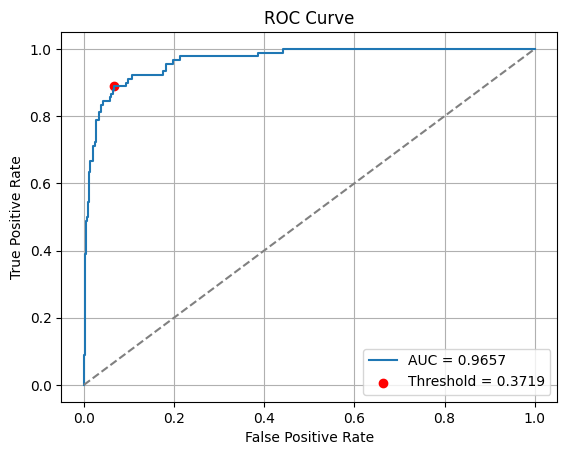

0.3718695640563965

In [1]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import os
from itertools import combinations
from retinaface import RetinaFace
from sklearn.metrics.pairwise import cosine_similarity
import onnxruntime
import cv2


def detect_and_align_face(img_path, target_size=(112, 112)):
    img = cv2.imread(img_path)
    faces = RetinaFace.detect_faces(img)
    if not isinstance(faces, dict) or len(faces) == 0:
        raise ValueError(f"No face detected in {img_path}")
    face_key = max(faces, key=lambda k: faces[k]["facial_area"][2] * faces[k]["facial_area"][3])
    x1, y1, x2, y2 = faces[face_key]["facial_area"]
    face = img[y1:y2, x1:x2]
    face = cv2.resize(face, target_size)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    return face.astype(np.float32)


def preprocess_image(face):
    face = face / 255.0
    face = (face - 0.5) / 0.5
    face = np.transpose(face, (2, 0, 1))
    face = np.expand_dims(face, axis=0)
    return face.astype(np.float32)


def load_model(onnx_path):
    session = onnxruntime.InferenceSession(onnx_path)
    input_name = session.get_inputs()[0].name
    return session, input_name


def get_embedding(session, input_name, img_tensor):
    embedding = session.run(None, {input_name: img_tensor})[0]
    return embedding / np.linalg.norm(embedding)


def compute_similarity(emb1, emb2):
    return float(cosine_similarity(emb1, emb2)[0][0])


def evaluate_threshold_roc(model_path, root_dir):
    session, input_name = load_model(model_path)

    # Tải embedding từng ảnh
    person_dirs = sorted([os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
    person_embeddings = {}

    for person_path in person_dirs:
        person_name = os.path.basename(person_path)
        embeddings = []
        for fname in os.listdir(person_path):
            img_path = os.path.join(person_path, fname)
            try:
                face = detect_and_align_face(img_path)
                emb = get_embedding(session, input_name, preprocess_image(face))
                embeddings.append((img_path, emb))
            except Exception as e:
                print(f"Skip {img_path}: {e}")
        if embeddings:
            person_embeddings[person_name] = embeddings

    # Tạo cặp same và diff
    same_scores, diff_scores = [], []

    for person, embs in person_embeddings.items():
        for (path1, emb1), (path2, emb2) in combinations(embs, 2):
            score = compute_similarity(emb1, emb2)
            same_scores.append(score)

    persons = list(person_embeddings.keys())
    for i in range(len(persons)):
        for j in range(i + 1, len(persons)):
            for _, emb1 in person_embeddings[persons[i]]:
                for _, emb2 in person_embeddings[persons[j]]:
                    score = compute_similarity(emb1, emb2)
                    diff_scores.append(score)

    # Tổng hợp nhãn và điểm
    scores = same_scores + diff_scores
    labels = [1] * len(same_scores) + [0] * len(diff_scores)

    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    best_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[best_idx]

    # In kết quả
    print(f"\n📊 AUC: {roc_auc:.4f} | Best Threshold: {best_threshold:.4f}")
    print(f"Mean same score: {np.mean(same_scores):.4f}")
    print(f"Mean diff score: {np.mean(diff_scores):.4f}")

    # Vẽ ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Threshold = {best_threshold:.4f}')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold

evaluate_threshold_roc(
    model_path="./models/edgeface_xs_gamma_06.onnx",
    root_dir="C:/Users/Trung/Downloads/Camera Roll - Copy - Copy/"
)

